In [1]:
#necessary libs
import numpy as np 
import random 
import scipy.signal as dsp
import scipy.fft as transform
import matplotlib.pyplot as plt
import cv2
import itertools
from struct import pack,unpack

In [21]:
# img1 and img2 are the 
# two input images 
img1 = cv2.imread('test.jpg') 
img2 = cv2.imread('grumpy.jpg')
# resize the coded image
img2_upscaled = cv2.resize(img2, (img1.shape[1],img1.shape[0]), interpolation = cv2.INTER_AREA)

### Metrics

In [22]:
def psnr(im1, im2):
    mse = np.mean((im1.astype(np.float64) / 255 - im2.astype(np.float64) / 255) ** 2)
    return 10 * np.log10(1. / mse)
def psnr_cv(im1, im2):
    return cv2.PSNR(im1, im2)

### LSB steganography method

In [23]:
### LSB Encryption method
# Encryption function 
def lsb_encrypt(img1, img2, k): 
    mask = 256 - 2**k
    stego = (img1 & mask) | (img2 >> (8 - k))            
    return stego
    
# Decryption function 
def lsb_decrypt(img, k): 
      
    mask = 2**k - 1
    output = (img & mask) << (8 - k)
      
    return output

In [24]:
# Test encryption
backup = img1
steg = lsb_encrypt(backup,img2_upscaled, 2)

In [25]:
print('PSNR: ', psnr(img1, steg), '\nCV2 PSNR: ', psnr_cv(img1, steg))

PSNR:  44.58758611124295 
CV2 PSNR:  44.58758611124295


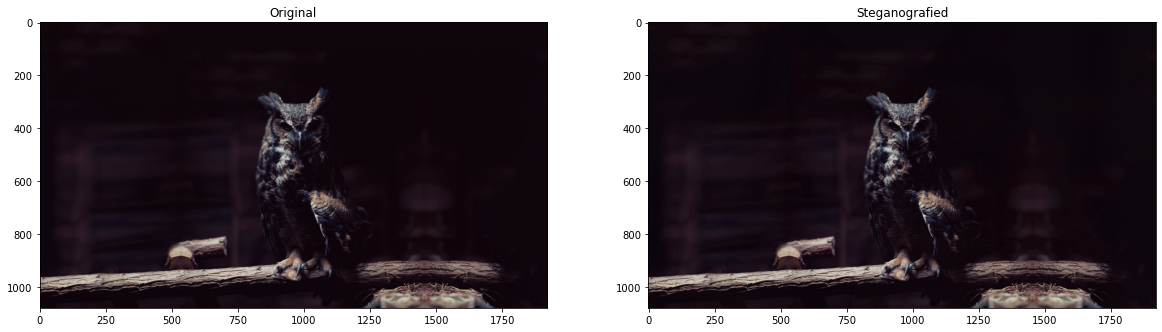

In [26]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 6))

ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax1.set_title("Original")

ax2.imshow(cv2.cvtColor(steg, cv2.COLOR_BGR2RGB))
ax2.set_title("Steganografied")

plt.show()

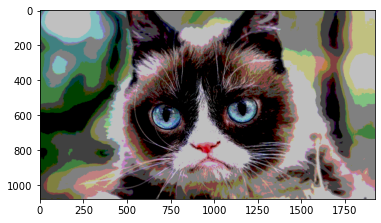

In [27]:
# Test decryption
secret = lsb_decrypt(steg, 2) 

plt.imshow(cv2.cvtColor(secret, cv2.COLOR_BGR2RGB))
plt.show()

In [28]:
print('PSNR: ', psnr(img2_upscaled, secret), '\nCV2 PSNR: ', psnr_cv(img2_upscaled, secret))

PSNR:  16.83080208300553 
CV2 PSNR:  16.830802083005537


In [29]:
#saving images
cv2.imwrite('lsb_steg.png', steg)
cv2.imwrite('lsb_extracted.png', secret)

True

### PVD (pixel value differencing) method

In [ ]:
### LSB Encryption method
# Encryption function 
def pvd_encrypt(img1, img2): 
    for i in range(img2.shape[0]): 
        for j in range(img2.shape[1]): 
            for l in range(3): 
                  
                # v1 and v2 are 8-bit pixel values 
                # of img1 and img2 respectively 
                v1 = format(img1[i][j][l], '08b') 
                v2 = format(img2[i][j][l], '08b') 
                  
                # Taking 4 MSBs of each image 
                v3 = v1[:4] + v2[:4]  
                  
                img1[i][j][l]= int(v3, 2) 
                
    return img1
    
      
# Decryption function 
def pvd_decrypt(img): 
      
    # Encrypted image 
    width = img.shape[0] 
    height = img.shape[1] 
      
    # img1 and img2 are two blank images 
    img1 = np.zeros((width, height, 3), np.uint8) 
    img2 = np.zeros((width, height, 3), np.uint8) 
      
    for i in range(width): 
        for j in range(height): 
            for l in range(3): 
                v1 = format(img[i][j][l], '08b') 
                v2 = v1[:4] + chr(random.randint(0, 1)+48) * 4
                v3 = v1[4:] + chr(random.randint(0, 1)+48) * 4
                  
                # Appending data to img1 and img2 
                img1[i][j][l]= int(v2, 2) 
                img2[i][j][l]= int(v3, 2) 
      
    return img1, img2

In [35]:
img2.shape

(540, 960, 3)

### DCT with LSB in Frequency domain

In [58]:
quant = np.array([[16,11,10,16,24,40,51,61],
                 [12,12,14,19,26,58,60,55],
                 [14,13,16,24,40,57,69,56],
                 [14,17,22,29,51,87,80,62],
                 [18,22,37,56,68,109,103,77],
                 [24,35,55,64,81,104,113,92],
                 [49,64,78,87,103,121,120,101],
                 [72,92,95,98,112,100,103,99]])

def chunks(l, n):
        m = int(n)
        for i in range(0, len(l), m):
            yield l[i:i + m]

## input - image, data to embed (gray image) 
def dct_encode(im_source, message):
    img = im_source
    row, col = img.shape[:2]
    
    secret = str(len(message))+'*'+message
    binary = str.encode(secret)
    for i in range(len(binary)):
        print(binary[i],end= ' ')
    print("\n")
    
    # Interpolate image up to the divisible blocks
    if row%8 != 0 or col%8 != 0:
        print('Resizing image up to: ', col+(8-col%8),row+(8-row%8))
        img = cv2.resize(img,(col+(8-col%8),row+(8-row%8)))
        row, col = img.shape[:2]
    
    # Check if the message could be potentially fitted
    print("Available capacity: ", int((row/8)*(col/8)), "bits")
    if len(message) >= ((row/8)*(col/8)):
        raise Exception("Message could not be fitted into cover image")
    
    # Split image into RGB channels
    img_b,img_g,img_r = cv2.split(img)
    img_b = np.float32(img_b)
    img_g = np.float32(img_g)
    img_r = np.float32(img_r)
    img_blocks = [img_b[j:j+8, i:i+8]-128 for (j,i) in itertools.product(range(0,row,8),range(0,col,8))]
    blocks_per_channel = len(img_blocks)
    img_blocks.extend([img_g[j:j+8, i:i+8]-128 for (j,i) in itertools.product(range(0,row,8),range(0,col,8))])
    img_blocks.extend([img_r[j:j+8, i:i+8]-128 for (j,i) in itertools.product(range(0,row,8),range(0,col,8))])
    
    # Making DCT transform
    dct_blocks = [np.round(cv2.dct(block)) for block in img_blocks]
    
    # Blocks then run through quantization table
    dct_blocks = [np.round(block/quant) for block in dct_blocks]
    
    messIndex = 0
    letterIndex = 0
        
    for i, block in enumerate(dct_blocks):
        for k in range(3):
            shift = k*blocks_per_channel
            b = dct_blocks[i+shift]
            #find LSB in DC coeff and replace with message bit
            DC = b[0][0]
            #print(DC, end=' ')
            DC = np.uint8(DC)
            DC = np.unpackbits(DC)
            #print(DC, end=' ')
            DC[7] = (binary[messIndex]>>letterIndex)&0b1
            #print((binary[messIndex]>>letterIndex)&0b1, end=' ')
            #print(DC,end= ' ')
            DC = np.packbits(DC).astype(np.int8)

            #print(DC,end= ' ')
            DC = np.float32(DC)
            #print(DC)
            b[0][0] = DC

        letterIndex = letterIndex+1
        if letterIndex == 8:
            letterIndex = 0
            messIndex = messIndex + 1
            if messIndex == len(binary):
                break
    # Inverse DCT
    inv_chunks = [block*quant for block in dct_blocks]
    inv_chunks = [cv2.idct(block)+128 for block in inv_chunks]
    
    restored=[]
    for k in range(3):
        channel=[]
        start = k*blocks_per_channel
        end = (k+1)*blocks_per_channel
        for chunkRowBlocks in chunks(inv_chunks[start:end], col/8):
            for rowBlockNum in range(8):
                for block in chunkRowBlocks:
                    channel.extend(block[rowBlockNum])
        channel = np.array(channel).reshape(row, col)
        restored.append(channel)
    
    #res = cv2.merge((restored[0],np.uint8(img_g),np.uint8(img_r)))
    res = cv2.merge((restored[0],restored[1],restored[2]))
    #res = cv2.convertScaleAbs(res)
    cv2.imwrite('dct_steg.png',res)
    return res

def dct_decode(img):
    row,col = img.shape[:2]

    messSize = None
    messageBits = []
    buff = 0

    #split image into RGB channels
    bImg,gImg,rImg = cv2.split(img)
    #print(bImg[0:16,0:16])
    #message hid in blue channel so converted to type float32 for dct function
    bImg = np.float32(bImg)
    
    #break into 8x8 blocks
    imgBlocks = [bImg[j:j+8, i:i+8]-128 for (j,i) in itertools.product(range(0,row,8),
                                                                       range(0,col,8))]    
    #blocks run through quantization table
    quantizedDCT = [cv2.dct(img_Block) for img_Block in imgBlocks]
    quantizedDCT = [img_Block/quant for img_Block in quantizedDCT]
    
    #print(quantizedDCT[1][0])
    i=0
    #message extracted from LSB of DC coeff
    for quantizedBlock in quantizedDCT:
        DC = quantizedBlock[0][0]
        ### Integer
        DC = np.uint8(DC)
        #print(DC, end=' ')
        DC = np.unpackbits(DC)
        if DC[7] == 1:
            buff+= 1<<i
        #print(DC)
        i=1+i
        if i == 8:
            #print(buff, end=' ')    
            messageBits.append(chr(buff))
            buff = 0
            i =0
            
            if messageBits[-1] == '*' and messSize is None:
                try:
                    messSize = int(''.join(messageBits[:-1]))
                except:
                    pass
        if len(messageBits) - len(str(messSize)) - 1 == messSize:
            return ''.join(messageBits)[len(str(messSize))+1:]

    return ''

In [59]:
dct_img = dct_encode(img1, 'Hello world!')

49 50 42 72 101 108 108 111 32 119 111 114 108 100 33 

Available capacity:  32400 bits


In [67]:
dct_decode(dct_img)

'Hello world!'

In [68]:
test_from_file = cv2.imread('dct_steg.png') 
dct_decode(test_from_file)

'Hello world!'

PSNR:  38.48342529961925 
CV2 PSNR:  38.5321110509279


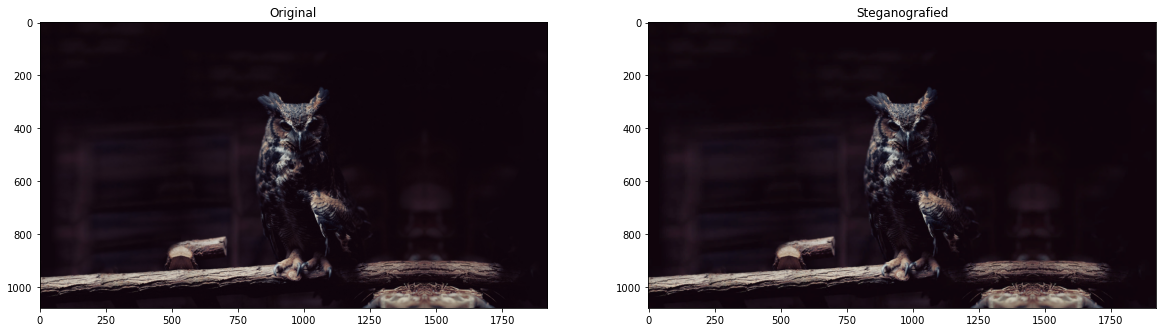

In [66]:
print('PSNR: ', psnr(img1, dct_img), '\nCV2 PSNR: ', psnr_cv(img1, cv2.convertScaleAbs(dct_img)))
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 6))

ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax1.set_title("Original")

ax2.imshow(cv2.cvtColor(cv2.convertScaleAbs(dct_img), cv2.COLOR_BGR2RGB))
ax2.set_title("Steganografied")

plt.show()

### Image DSP analysis

In [1]:
### DFT analysis
# DSP Library for python
import scipy.signal as dsp
import scipy.fft as transform
import matplotlib.pyplot as plt
import numpy as np 
import cv2

In [2]:
%matplotlib inline

In [3]:
test = cv2.imread('grumpy.jpg') 
# Image in BGR mode
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
test.shape

(540, 960, 3)

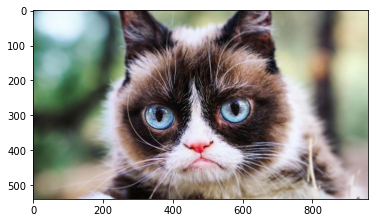

In [4]:
plt.imshow(test)

In [6]:
# Backup
cv2.imshow("test", test)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
freqs = transform.fft2(test)
freqs.shape

(540, 960, 3)

In [6]:
real = np.real(freqs)
#real = transform.fftshift(real)
real = transform.fftshift(real, axes=(0,1,))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


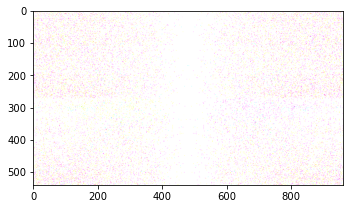

In [7]:
magnitude = 20*np.log(np.abs(real))
plt.figure(figsize=(6, 3.2))
plt.imshow(magnitude)

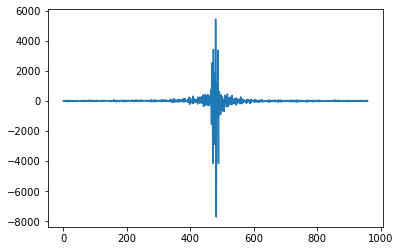

In [27]:
plt.plot(real[100,:,1])

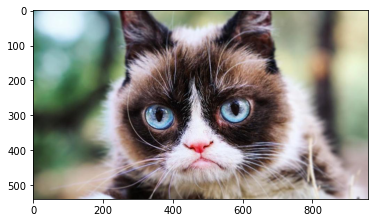

In [8]:
# Restoring image
restore = np.real(transform.ifft2(freqs))
# Converting double to 8 bits unsigned integer value
restore = restore.astype(np.uint8)
# Plotting
plt.imshow(restore)

In [9]:
(test-restore).mean()

0.2116943158436214

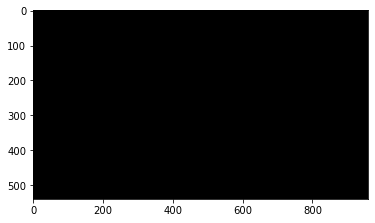

In [10]:
plt.imshow(test - restore)

In [14]:
save = cv2.cvtColor(restore, cv2.COLOR_RGB2BGR)
cv2.imwrite('ifft.jpg', save)

True

### Simple frequency domain convolve

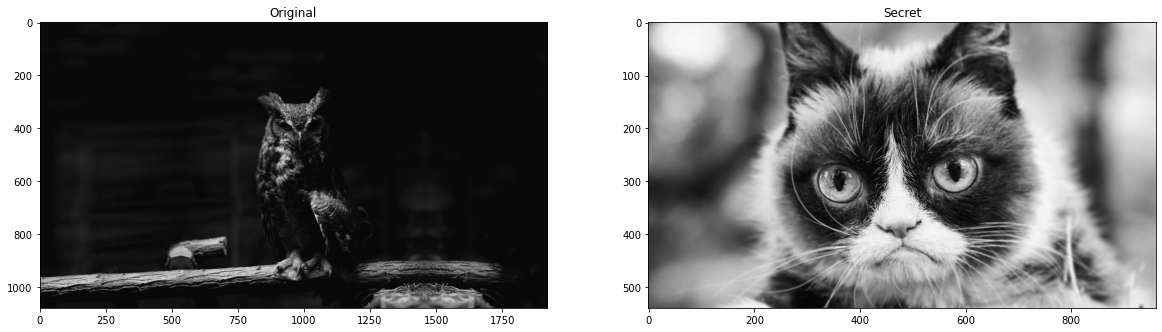

In [72]:
img1 = cv2.imread('test.jpg') 
img2 = cv2.imread('grumpy.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 6))

ax1.imshow(img1,cmap='gray')
ax1.set_title("Original")

ax2.imshow(img2,cmap='gray')
ax2.set_title("Secret")

plt.show()

In [80]:

### DFTIAT algorithm
# https://link.springer.com/content/pdf/10.1007%2F978-3-642-20998-7.pdf
# pp 336-341

def DFTIAT_GS_ENCODE(im_source, im_embed):
    image = im_source
    message = im_embed.flatten().astype(np.uint8).tobytes()
    print(len(message))
    # Checking limiting parameter
    if (len(message) >= (image.shape[0]*image.shape[1]*3/4 - 16)): 
        raise Exception("Message could not be fitted into cover image")
    
    # word counter
    c = 0
    # bit counter
    b = 0
    # Sliding 2x2 Window of cover image
    for i in range (0,(image.shape[0]-2)):
        for j in range (0,(image.shape[1]-2)):
            # Taking 2x2 window
            window = image[i:i+2,j:j+2]
            # Process Fourier Transform and take the real part
            fd = transform.fft2(window)
            r = np.real(fd).astype(int).flatten()
            # Assign LSB to embedding image bit, skipping first freq component
            ## Gathering bits 
            bits = 0
            if(c < len(message)):
                if b <= 5:
                    # we do not need to select the next word
                    bits = (message[c]>>b)&0b00000111 #Take last 3 bits with shift by bit counter
                else:
                    # selecting next word
                    residual = 8 - b
                    bits = (message[c]>>b)&(2**residual-1) # Take residual part of the current value
                    if(c < len(message)-1):
                        c += 1 # Select next byte
                        b = residual # Assign residual part for next byte
                        bits += (message[c]>>b)&0b111 # Take part of the next value
                    else:
                        break
                b += 3
            else:
                break
        if(c >= len(message)):
            break
            ##
            # Setting bits
            for k in range(0,3,1):
                r[k+1] += (bits>>k)&1  # Assigning bit to the frequency tap
            # Taking inverse transform
            chunk = np.reshape(r, (-1, 2))
            image[i:i+2,j:j+2] = np.real(transform.ifft2(chunk))
    # Converting double to 8 bits unsigned integer value
    #res = image.astype(np.uint8)
    res = image
    return res

def DFTIAT_GS_DECODE(im_coded, height, width):
    image = im_coded
    size = height*width
    sequence = []
    word = 0
    # word counter
    c = 0
    # bit counter
    b = 0
    
    # Sliding 2x2 Window of cover image
    for i in range (0,(im_coded.shape[0]-2)):
        for j in range (0,(im_coded.shape[0]-2)):
            # Taking 2x2 window
            window = image[i:i+2,j:j+2]
            # Process Fourier Transform and take the real part
            fd = transform.fft2(window)
            r = np.real(fd).astype(int).flatten()
            # Take last 3 values
            for k in range(1,4,1):
                value = r[k]
                #Take LSB from freq response
                LSB = value&1
                word = (word<<b)|LSB
                b += 1
                if b == 8:
                    b = 0
                    c += 1;
                    sequence.append(np.uint8(word))
                r[k] = value^(1<<0)
            chunk = np.reshape(r, (-1, 2))
            image[i:i+2,j:j+2] = np.real(transform.ifft2(chunk))
            #print(word, sequence)
            if (c >= size):
                break
        if (c >= size):
            break
    
    np_array = np.frombuffer(bytearray(sequence), dtype=np.uint8)
    
    h = 0
    w = 0
    print(c)
    secret = np.zeros([height, width], dtype=int)
    for i in range(0, len(np_array)):
        secret[h,w] = np_array[i]
        if w >= width - 1:
            h += 1
            w = 0
        if h >= height - 1:
            break
        w += 1
    # Converting double to 8 bits unsigned integer value
    #res = image.astype(np.uint8)
    #res = image
    return image, secret

In [81]:
x = DFTIAT_GS_ENCODE(img1,img2)

518400


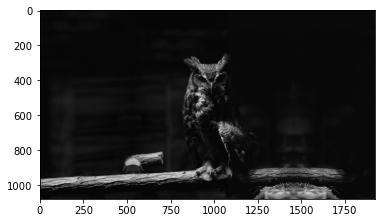

In [82]:
plt.imshow(x,cmap='gray')

In [83]:
cv2.imwrite('DFTIAT.jpg', x)

True

In [84]:
cv2.imwrite('gray.jpg', img1)

True

In [85]:
cover, secret = DFTIAT_GS_DECODE(x, img2.shape[0], img2.shape[1])

435781


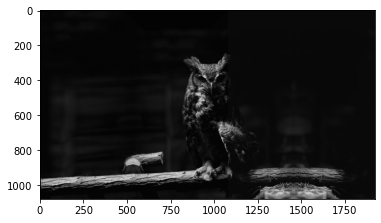

In [86]:
plt.imshow(cover,cmap='gray')

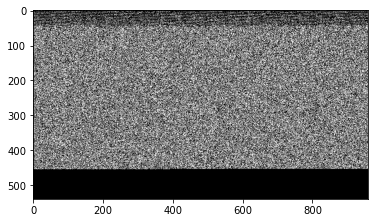

In [87]:
plt.imshow(secret,cmap='gray')

In [88]:
cv2.imwrite('DFTIAT_secret.jpg', secret)

True

In [89]:
secret

array([[  0,   0,   0, ..., 129, 128,   0],
       [  0, 129,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   1, 129,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [128]:
secret.min()

0